In [16]:
import joblib

#Loading vectorzer
vectorizer = joblib.load("../models/tfidf_vectorizer.pkl")

#Loading label encoder
label_encoder = joblib.load("../models/label_encoder.pkl")


In [17]:
# 1. Import libraries
import pandas as pd

# 2. Load CSV
df = pd.read_csv('../data/Resume.csv')  # Adjust path if needed

# 3. Basic info
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# 4. View sample data
df.head()

Shape: (2484, 4)

Columns: ['ID', 'Resume_str', 'Resume_html', 'Category']


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [18]:
print("\nNumber of categories:", df['Category'].nunique())
print("\nCategory counts:\n", df['Category'].value_counts())


Number of categories: 24

Category counts:
 Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64


In [19]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # for lemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_resume(text):
    # Convert to string if not already
    text = str(text)
    
    # Lowercase
    text = text.lower()
    
    # Remove numbers, punctuations, special chars
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

df['cleaned_resume'] = df['Resume_str'].apply(clean_resume)
df[['Category', 'cleaned_resume']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tushar04master/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tushar04master/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/tushar04master/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Category,cleaned_resume
0,HR,hr administrator marketing associate hr admini...
1,HR,hr specialist u hr operation summary versatile...
2,HR,hr director summary year experience recruiting...
3,HR,hr specialist summary dedicated driven dynamic...
4,HR,hr manager skill highlight hr skill hr departm...


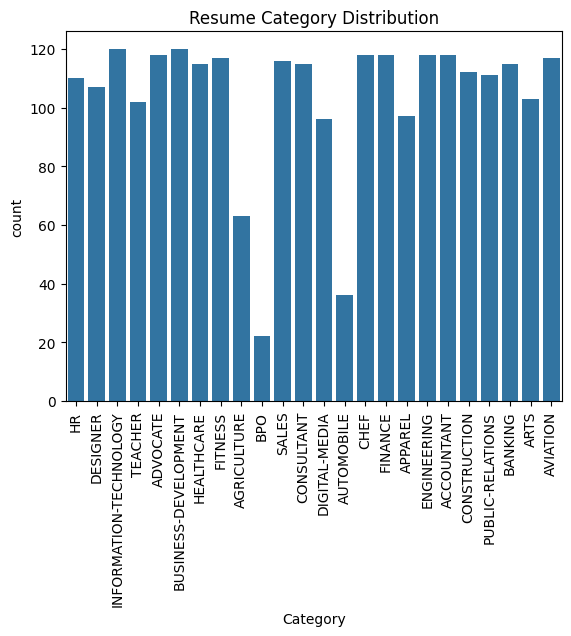

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='Category', data=df)
plt.xticks(rotation=90)
plt.title("Resume Category Distribution")
plt.show()

 ### We will use GridSearchCV on XGBOOST as it automates the process of finding the best values for tuning these hyperparameters.

In [7]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['cleaned_resume'])
print("TF-IDF Shape:", X.shape)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Category'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create XGBoost model (now with parallelism)
model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    n_jobs=-1  # <- Parallelize training inside XGBoost
)

# Define param grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}

# Grid Search CV with parallelism
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=3,
    n_jobs=-1  # <- Parallelize grid search
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get best model from grid search
best_model = grid_search.best_estimator_

# Evaluate
y_pred = best_model.predict(X_test)

print("✅ Best Parameters:", grid_search.best_params_)
print("✅ Best CV Score:", grid_search.best_score_)
print("✅ Test Accuracy:", accuracy_score(y_test, y_pred))

print("\n📄 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))
print("📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

TF-IDF Shape: (2484, 3000)
Fitting 3 folds for each of 36 candidates, totalling 108 fits
✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
✅ Best CV Score: 0.7453547380684399
✅ Test Accuracy: 0.7505030181086519

📄 Classification Report:

                        precision    recall  f1-score   support

            ACCOUNTANT       0.93      0.97      0.95        29
              ADVOCATE       0.87      0.87      0.87        30
           AGRICULTURE       0.57      0.50      0.53         8
               APPAREL       0.61      0.55      0.58        20
                  ARTS       0.38      0.33      0.35        18
            AUTOMOBILE       0.40      0.33      0.36         6
              AVIATION       0.86      0.90      0.88        21
               BANKING       0.70      0.61      0.65        23
                   BPO       1.00      0.50      0.67         2
  BUSINESS-DEVELOPMENT       0.84      0.59      0.70        27
          

In [11]:
import joblib
joblib.dump(best_model, '../models/xgb_best.pkl')

['../models/xgb_best.pkl']

In [54]:
# Load vectorizer and model
vectorizer = joblib.load('../models/tfidf_vectorizer.pkl')
model = joblib.load('../models/xgb_best.pkl')
label_encoder = joblib.load('../models/label_encoder.pkl')

# Predict
resume_text = "Passionate educator committed to fostering academic excellence and holistic student development."
vector = vectorizer.transform([resume_text])
prediction = model.predict(vector)

# Using LabelEncoder to decode this predicted category

# Decode the predicted label
decoded_category = label_encoder.inverse_transform(prediction)[0]
print("Predicted Category (decoded):", decoded_category)

Predicted Category (decoded): BUSINESS-DEVELOPMENT
